
   
# Notebook 2: Statistiek bepalen
*auteur: S. Klop*
    
In dit notebook wordt behandelt hoe tijdreeksanalyse (TRA) gebruikt kan worden voor het bepalen van karakteristieke waarde van de meetreeks. Hierbij worden onder andere het bepalen van GXG's behandelt.





In [1]:
# inladen van de benodigde python packages
import pastas as ps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

%matplotlib inline
ps.set_log_level("ERROR")


## Deel I: Inschatten GXG voor korte reeks

Het waterschap heeft de grondwaterstand gemeten in Peilbuis A vanaf 1 augustus 2010 tot 28 juli 2015, een totale periode van 5 jaar. Dit is de enige peilbuis in het gebied, het Waterschap wil toch graag een inschatting maken van de GXG binnen het gebied. De reeks die gemeten is in peilbuis A is hiervoor te kort (<8 jaar). 

Met behulp van tijdreeksanalyse wordt een inschatting gemaakt van de GXG in het gebied.


### Beschikbare gegevens
De gemeten grondwaterstand is te zien in de onderstaande afbeelding. De gemeten grondwaterstand varieert tussen de 27.2 en 28.7 m NAP. 

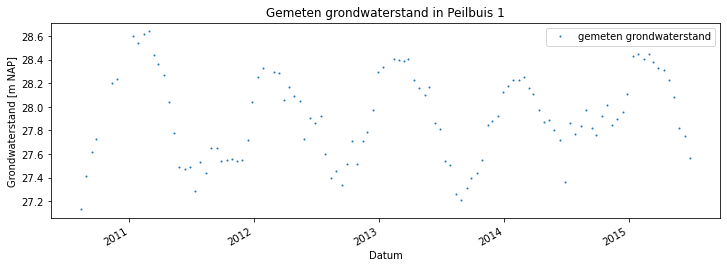

In [2]:
gws = pd.read_csv("data/head.csv",
                   index_col=0, parse_dates=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
# gws[:'2010-08-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=2)
gws['2010-08-01':].plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van Peilbuis A. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. Te zien is dat deze meetreeksen teruggaan tot 1980, en dus langer zijn dan de gemeten grondwaterreeksen. 

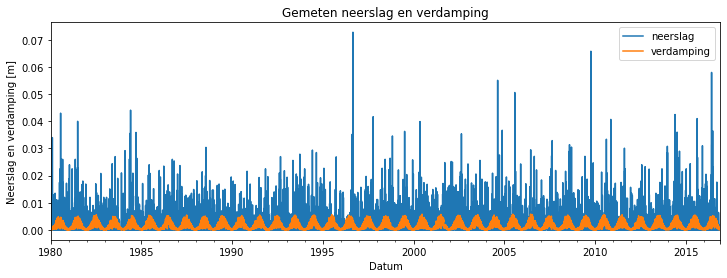

In [3]:
neerslag =  pd.read_csv("data/rain.csv",
                    index_col=0, parse_dates=True)
verdamping =  pd.read_csv("data/evap.csv",
                    index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);

### Opstellen van het tijdreeksmodel

De eerste stap voor het opstellen van het model is het toevoegen van de grondwater observaties aan het model. Voor een eerste berekening wordt de grondwater reeks gebruikt tot aan de huidige datum (niet de "toekomstige" grondwaterstand). In de reeks zijn geen uitschieters gevonden, er is daarom geen reden om de meetreeks voor te bewerken.

De neerslag en verdamping worden toegevoegd aan het model als verklarende reeksen. Om de verklaarende reeksen toe te voegen moet een `respons functie` worden toegekent aan de verklarende reeks (in dit geval regen en verdamping). De respons functie beschrijft de reactie van de grondwaterstand op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type respons functie kiest en waarbij het tijdreeksmodel de parameters van deze functie optimaliseerd. Voor het tijdreeksmodel wordt gebruikt gemaakt van de Gamma respons functie voor de neerslag en verdamping. 

In het tijdreeksmodel wordt dezelfde response functie gebruikt voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule:

$ R = P - f * E$

waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd naast de parameters voor de Gamma respons functie.

De resultaten van het geoptimaliseerde tijdreeksmodel zijn te zien in de onderstaande tabel.

In [4]:
# opzetten model
ml = ps.Model(gws['2010-08-01':])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve()

# simuleren van de grondwaterstand
gws_simulatie1 = ml.simulate()

Fit report head                             Fit Statistics
nfev     21                     EVP                     92.24
nobs     112                    R2                       0.93
noise    True                   RMSE                     0.10
tmin     2010-08-14 00:00:00    AIC                     11.83
tmax     2015-06-28 00:00:00    BIC                     28.14
freq     D                      Obj                      0.33
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           Interpolated               No

Parameters (6 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  568.508388  ±15.86%  215.674528  True
grondwateraanvulling_n    1.024965   ±4.34%    1.000000  True
grondwateraanvulling_a  140.248179  ±18.52%   10.000000  True
grondwateraanvulling_f   -1.404997  ±10.98%   -1.000000  True
constant_d               28.030114   ±0.48%   27.914732  True
noise_alpha              33.805562  ±27.23

Te zien is dat het tijdreeksmodel een hoge verklaarde variantie heeft van 92% en een R$^2$ van 0.93. In de onderstaande afbeelding is het resultaat van de simulatie van de grondwaterstand door het tijdreeksmodel weergeven. Hierin zijn de bijdrages van de neerslag en verdamping weergeven. Hier is ook duidelijk het seizoensgebonden effect van de verdamping te zien. 

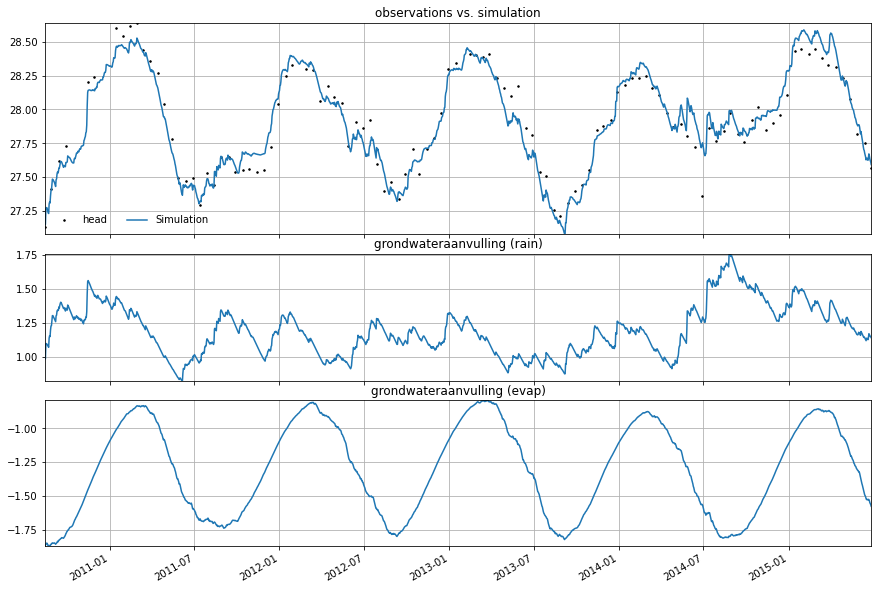

In [5]:
ml.plots.decomposition(figsize=(12,8));

### bepalen GXG

De meetreeks is te kort om de GXG ter plaatse van de peilbuis te bepalen. Met behulp van het tijdreeksmodel kan de grondwaterstand op basis van de historische neerslag en verdampingsdata worden gesimuleerd, immers is er met het tijdreeksmodel een inschatting gemaakt voor de relatie tussen de neerslag/verdamping en de grondwaterstand. De grondwaterstand kan worden gesimuleerd tot aan de start van de neerslag en verdampingsmeetreeksen. Hierbij wordt de aanname gedaan dat het hydrologische systeem in deze periode niet is verandert en dat de gevonden relatie gelijk is gebleven.

In de onderstaande afbeelding is de gesimuleerde reeks te zien vanaf 1980 (het moment waarop de neerslag en verdampingsdata beschikbaar is). Op basis van deze reeks kunnen de GXG's worden bepaald.

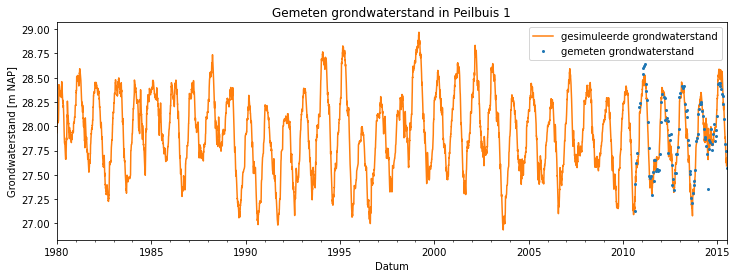

In [6]:
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ml.simulate(tmin=1980).plot(ax=ax, color='C1')
gws['2010-08-01':].plot(ax=ax, color='C0', ls='', marker='o', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend(['gesimuleerde grondwaterstand',f'gemeten grondwaterstand']);
ax.set_xlim(xmin='1980');

In de onderstaande tabel zijn de GXG's weergeven in m NAP. Hierin zijn eerste GXG's weergeven voor de meetreeks en de simulatie vanaf 1 aug 2010 tot 28 juni 2015. Deze GXG waardes zijn gebaseerd op deze korte meetperiode, dus niet voor minimaal 8 jaar. Daarna zijn de GXG waardes weergeven voor de gesimuleerde reeks vanaf 1980. 

Te zien is dat de berekende GXG waardes weinig afwijken (tot maximaal 0.1 m). De grootste afwijking is hierbij te zien voor de GHG. 

In [7]:
# GXG bepalen voor de verschillende reeksen
df = pd.DataFrame()
df.loc['meetreeks vanaf 2010-08-01','GLG'] = ps.stats.glg(gws['2010-08-01':]['head'], min_n_years=3)
df.loc['meetreeks vanaf 2010-08-01','GHG'] = ps.stats.ghg(gws['2010-08-01':]['head'], min_n_years=3)
df.loc['tijdreeksmodel vanaf 2010-08-01','GLG'] = ps.stats.glg(ml.simulate(), min_n_years=3)
df.loc['tijdreeksmodel vanaf 2010-08-01','GHG'] = ps.stats.ghg(ml.simulate(), min_n_years=3)
df.loc['tijdreeksmodel vanaf 1980','GLG'] = ps.stats.glg(ml.simulate(tmin='1980'), min_n_years=8)
df.loc['tijdreeksmodel vanaf 1980','GHG'] = ps.stats.ghg(ml.simulate(tmin='1980'), min_n_years=8)

display(df)

,GLG,GHG
meetreeks vanaf 2010-08-01,27.418333,28.348333
tijdreeksmodel vanaf 2010-08-01,27.418433,28.424302
tijdreeksmodel vanaf 1980,27.414186,28.443489


Na het uitvoeren van de analyse is toch de verdere meetreeks van Peilbuis A teruggevonden, deze meetreeks is vanaf 1985. Het waterschap besluit om de eerdere analyse de controleren met de nieuw gevonden data. De resultaten hiervna zijn toegevoegd aan de onderstaande tabel.

Te zien is dat de GHG overeenkomt met de gevonden waardes op basis van het tijdreeksmodel. Voor de GLG is een afwijking van ca. 0.1 m te zien. Waarbij het tijdreeksmodel de GLG licht heeft overschat.

In [8]:
df.loc['controle nieuwe metingen','GLG'] = ps.stats.glg(gws['head'], min_n_years=3)
df.loc['controle nieuwe metingen','GHG'] = ps.stats.ghg(gws['head'], min_n_years=3)

display(df)

,GLG,GHG
meetreeks vanaf 2010-08-01,27.418333,28.348333
tijdreeksmodel vanaf 2010-08-01,27.418433,28.424302
tijdreeksmodel vanaf 1980,27.414186,28.443489
controle nieuwe metingen,27.306667,28.446173


## Deel II: Invullen missend deel van meetreeks

In peilbuis PB05 van het waterschap is de grondwaterstand gemeten. Het waterschap wil inzicht krijgen in de GXG in het gebied. Echter zijn in peilbuis PB05 geen meetgegevens beschikbaar voor het jaar 2018. In dit jaar is de grondwaterstand in het gebied zeer laag geweest. De GXG waardes op basis van de afgelopen 8 jaar wordt beinvloed door de lage grondwaterstanden in 2018, dit zal voornamelijk in de GLG te zien zijn. 

Op basis van de huidige reeks is het niet mogelijk om de GXG waardes te bepalen. Daarom wordt gebruik gemaakt van tijdreeksanalyse om de meetreeks op te vullen. Op basis van deze reeks worden de GXG's bepaald.


###  Beschikbare gegevens
De gemeten grondwaterstand is te zien in de onderstaande afbeelding. De meetperiode van de peilbuis is 1985 tot 2020, waarbij in het jaar 2018 geen grondwaterstanden zijn gemeten.


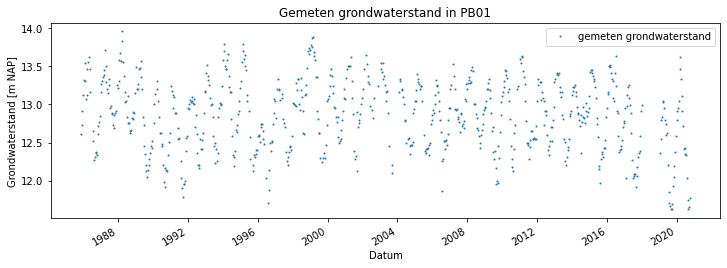

In [9]:
gws = pd.read_csv(r'data/PB05.csv', index_col=0, parse_dates=True)
gws = gws[~gws.index.year.isin([2018])]
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in PB01')
ax.legend([f'gemeten grondwaterstand']);

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van de peilbuis. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. 

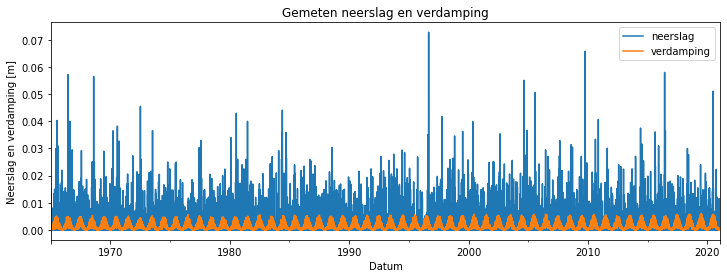

In [10]:
neerslag = pd.read_csv('data/neerslag.csv', index_col=0, parse_dates=True)
verdamping = pd.read_csv('data/verdamping.csv', index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);


### Opzetten tijdreeksmodel

Er wordt een tijdreeksmodel opgesteld op basis van de meetreeks in PB05. Hiervoor worden de neerslag en verdamping gebruikt als verklarende reeks. Voor de neerslag en verdamping wordt de Exponentiele respons functie gebruikt in de tijdreeksanalyse.

De resultaten van het tijdreeksmodel zijn weergeven in de onderstaande tabel. 

In [11]:
# opzetten model
ml = ps.Model(gws)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Exponential,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve()

Fit report PB05_1                           Fit Statistics
nfev     13                     EVP                     92.51
nobs     746                    R2                       0.92
noise    True                   RMSE                     0.12
tmin     1985-11-14 00:00:00    AIC                      5.10
tmax     2020-09-28 00:00:00    BIC                     28.17
freq     D                      Obj                      2.91
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           Interpolated               No

Parameters (5 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  708.419140   ±4.93%  219.794219  True
grondwateraanvulling_a  161.843252   ±4.64%   10.000000  True
grondwateraanvulling_f   -1.301380   ±4.06%   -1.000000  True
constant_d               12.909907   ±0.47%   12.859290  True
noise_alpha              46.129886  ±10.74%   15.000000  True

Parameter correlations |rho| > 0.5
grondw

De gemeten grondwaterstand is te zien in de onderstaande afbeelding met de gesimuleerde grondwaterstand met het tijdreeksmodel. Hierin is te zien dat het tijdreeksmodel de grondwaterstand goed simuleerd. Wel is hierbij te zien dat de data van 2018 ontbreekt. Het tijdreeks model simuleerd voor de zomer van 2018 een lage grondwaterstand, vergelijkbaar met de gemeten grondwaterstand in de zomer van 2019 in deze peilbuis. 

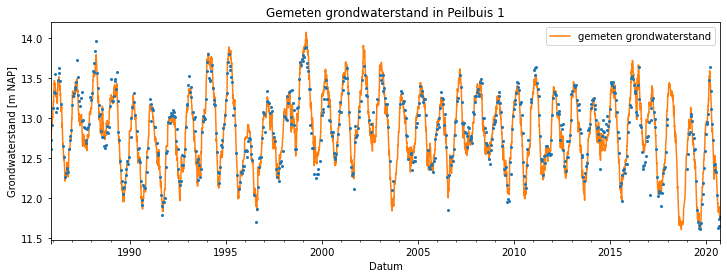

In [12]:
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ml.simulate().plot(ax=ax, color='C1')
gws.plot(ax=ax, color='C0', ls='', marker='o', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);


In de onderstaande tabel zijn de GXG waardes weergeven die zijn berekend met behulp van de gesimuleerde tijdreeks. Hierbij is het droge jaar 2018 meegenomen ook al zijn voor dit jaar geen metingen beschikbaar. Voor deze analyse moet worden opgemerkt dat de aanname is gemaakt dat het grondwatersysteem in het jaar 2018 een verlijkbare respons heeft op de neerslag en verdamping als in andere jaren, ondanks de extreme droogte. 

In [16]:
df = pd.DataFrame()
df.loc['tijdreeksmodel','GLG'] = ps.stats.glg(ml.simulate(), min_n_years=8)
df.loc['tijdreeksmodel','GHG'] = ps.stats.ghg(ml.simulate(), min_n_years=8)

display(df)

,GLG,GHG
tijdreeksmodel,12.27286,13.434438
